# Explore wiki project data faster with `mwsql`

The `mwsql` library is the latest addition to [MediaWiki-utilities](https://www.mediawiki.org/wiki/Mediawiki-utilities), a collection of lightweight Python tools for extracting and processing MediaWiki data. It provides a simple interface for downloading, inspecting, and transforming SQL dump files into other more user-friendly formats such as Pandas dataframes or CSV. `mwsql` is available through PyPI and can be installed using `pip`.

## Why mwsql?

Data from Wikimedia projects is open-source licensed and publicly available in a variety of formats, such as:

* [Data dumps](https://dumps.wikimedia.org/) in SQL, XML, and HTML format
* [Database replicas](https://wikitech.wikimedia.org/wiki/Portal:Data_Services#Wiki_Replicas) thorough Toolforge, PAWS, or Quarry
* [API endpoints](https://www.mediawiki.org/wiki/API:REST_API/Reference)

While utilities for working with most of these data sources have existed for quite some time, for example `mwapi` and `mwxml`, no such tool existed for SQL dumps. Because of this gap, developing `mwsql` was proposed as a joint [Outreachy](https://www.mediawiki.org/wiki/Outreachy) project between the Research and Technical Engagement teams during the May-August round of 2021.

## SQL dumps

Before diving into exploring the different features of `mwsql`, let's take a look at what a raw SQL dump file looks like.

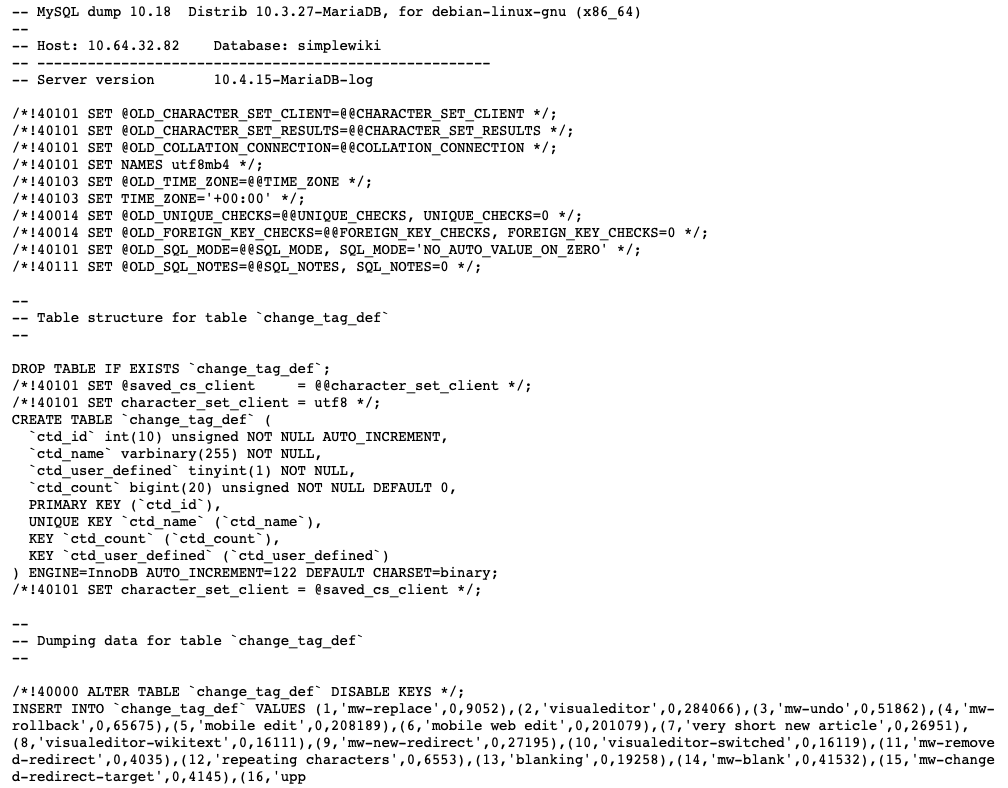

The dump contains information related to the database table structure, as well as the actual table contents (records) in the form of a list of SQL statements. There is also some additional metadata. Database dumps are most often used for backing up a database so that its contents can be restored in the event of data loss. They are not designed to be worked with 'as is', e.g., parsed, filtered or searched. However, having the ability to access data directly from the dumps allows offline processing and lowers the barrier for users with only basic Python knowledge, such as data scientists, researchers, or journalists because the only prerequisite is basic Python knowledge.

## `mwsql` features

`mwsql` main features are:

* easily downloading SQL dump files
* parsing the database table into a `Dump` object
* allowing fast exploration of the table's metadata and contents 
* transforming the SQL dump into other more convenient data structures and file formats

The rest of this tutorial will demonstrate each of these features through a concrete example.

## Use `mwsql` with a Wiki data dump

Let's use the [Simple English Wikipedia](https://simple.wikipedia.org/wiki/Main_Page) database 'simplewiki'. The latest dumps can be found [here](https://dumps.wikimedia.org/simplewiki/).

### Downloading dump files

If you access the dump files from a WMF-hosted environment, `mwsql` recognizes this and simply creates a pointer to the public directory where the dump file is found. If you are working on your local machine, the load function first downloads the dump file to your current working directory, and then creates a pointer to it once the download is complete.

By default, `mwsql`'s load function assumes that you want the 'latest' version of the dumps, but you can add a specific date as an optional parameter. If you don't use 'latest' , the date format should be 'YYYYMMDD'. Now, let's see this in action.

In [ ]:
!pip install mwsql

In [2]:
from mwsql import load

# Load 'simplewiki-latest-category.sql.gz'
dump_file = load('simplewiki', 'category')
# Load 'simplewiki-20220301-category.sql.gz'
dump_file_older = load('simplewiki', 'category', date='20220301')

100%|██████████████████████████████████████████████████████| 660k/660k [00:00<00:00, 1.16MiB/s]
100%|██████████████████████████████████████████████████████| 660k/660k [00:00<00:00, 1.22MiB/s]


The example above is from a locally-run Jupyter notebook, so the files were downloaded displaying a progress bar. Once the download is complete, the files can be found in the same directory as the notebook.

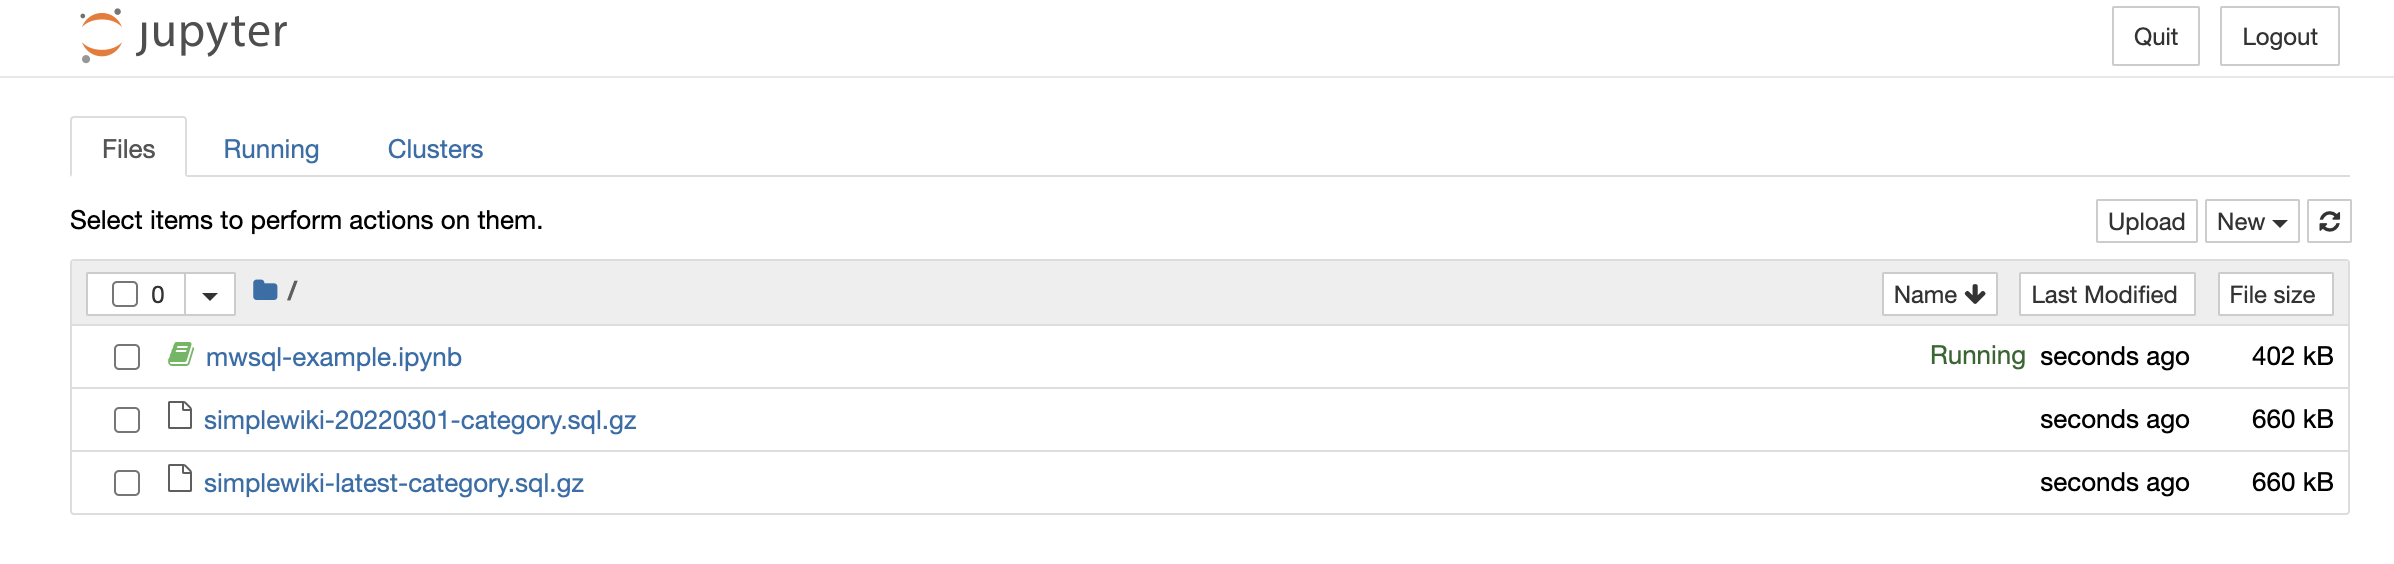

### Parsing the SQL dump file

Now that we have access to the files, we can start exploring. Note that we haven't had to worry about where to download the files from, nor whether they're compressed (.gz). If the files weren't compressed, everything would work just the same, as `mwsql` takes care of all the details in the background.

In [3]:
from mwsql import Dump

# Create a Dump object
dump = Dump.from_file(dump_file)

### Exploring the data

In just two lines of code, we have created a Dump object that contains all the data from the file. Well, not exactly. If we were working with a very large file -- and most of the dump files are indeed very large -- we would quickly run out of memory if we tried ingesting all the file contents at once.

In practice, most of the parsing happens only when we explicitly request the rows, or records, of the table. The file contents are processed sequentially, holding only parts of the file in memory. No matter how large the file is, we will not run out of RAM.

Let's start exploring the data.

In [4]:
# Display the first 10 rows in the table
dump.head()

['cat_id', 'cat_title', 'cat_pages', 'cat_subcats', 'cat_files']
['1', 'Category_needed', '21', '1', '0']
['2', 'Articles_that_need_to_be_wikified', '49', '48', '0']
['4', 'South_Korea', '26', '16', '0']
['6', '1780s', '20', '17', '0']
['7', 'Matter', '25', '3', '0']
['8', '2007', '21', '16', '0']
['10', 'Germany', '50', '24', '0']
['11', '1985', '16', '10', '0']
['13', '"Politics_of"_templates', '5', '0', '0']
['14', '0s', '12', '5', '0']


The `head` method displays the first rows as lists of strings. The very first row contains the column names, followed by the table records. By default, ten rows are shown, but you can choose to display any number by passing it in as an argument:

In [5]:
dump.head(3)

['cat_id', 'cat_title', 'cat_pages', 'cat_subcats', 'cat_files']
['1', 'Category_needed', '21', '1', '0']
['2', 'Articles_that_need_to_be_wikified', '49', '48', '0']
['4', 'South_Korea', '26', '16', '0']


We can also get some metadata:

In [6]:
print(f'database name: {dump.db}')
print(f'table name: {dump.name}')
print(f'primary key: {dump.primary_key}')
print(f'encoding: {dump.encoding}', end='\n\n')

for key, val in dump.sql_dtypes.items():
    print(f'{key}: {val}')

database name: simplewiki
table name: category
primary key: ['cat_id']
encoding: utf-8

cat_id: int(10) unsigned NOT NULL AUTO_INCREMENT
cat_title: varbinary(255) NOT NULL DEFAULT ''
cat_pages: int(11) NOT NULL DEFAULT 0
cat_subcats: int(11) NOT NULL DEFAULT 0
cat_files: int(11) NOT NULL DEFAULT 0


For all available types of metadata, see the `mwsql` [documentation](https://mwsql.readthedocs.io/en/latest/index.html).

You may have noticed that the primary key is a list containing only one item. The reason for this is that a SQL table can have more than one primary key.

All Wikimedia SQL dumps are encoded using `utf-8`. Unfortunately, some fields can contain non-recognized characters, raising an encoding error when attempting to parse the dump file. If this happens, you many need to try experimenting with different encodings, such as `latin-1` or `ISO 8859-1`. You can learn more about this, and other, known issues in the [documentation](https://mwsql.readthedocs.io/en/latest/readme.html#known-issues).

While the `head` method printed out all the data as strings, we can also access the rows and request proper Python data types:

In [7]:
rows = dump.rows(convert_dtypes=True)
for _ in range(5):
    print(next(rows))

[1, 'Category_needed', 21, 1, 0]
[2, 'Articles_that_need_to_be_wikified', 49, 48, 0]
[4, 'South_Korea', 26, 16, 0]
[6, '1780s', 20, 17, 0]
[7, 'Matter', 25, 3, 0]


Neat. However, anyone serious about working with the data from the SQL dumps probably knows that core Python alone won't do it. `mwsql` is not meant to be a substitute for the real deal, but a bridge to whatever tools are in our data science treasure chest. We have two options here: the first is turning the `Dump` object directly into a more fitting data structure, and the second is to convert the `Dump` to CSV, which is a file format that is universally supported by data science and big data libraries and frameworks. As an example of the first option, here is how we could create a Pandas DataFrame, in one line of code:

In [8]:
import pandas as pd

# create the Pandas Dataframe
category_df = pd.DataFrame(dump.rows(convert_dtypes=True), columns=dump.col_names)

# display first five records
category_df.head()

,cat_id,cat_title,cat_pages,cat_subcats,cat_files
0,1,Category_needed,21,1,0
1,2,Articles_that_need_to_be_wikified,49,48,0
2,4,South_Korea,26,16,0
3,6,1780s,20,17,0
4,7,Matter,25,3,0


Let's get some info about the Dataframe:

In [9]:
category_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58069 entries, 0 to 58068
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cat_id       58069 non-null  int64 
 1   cat_title    58069 non-null  object
 2   cat_pages    58069 non-null  int64 
 3   cat_subcats  58069 non-null  int64 
 4   cat_files    58069 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 2.2+ MB


We can see that the Dataframe has approximately 58k rows, and that it uses around 2.2 MB of memory. That is of course a lot of Wikipedia categories, but as dataset sizes go, it's on the tiny side. Contrary to mwsql's `Dump` object, Pandas will attempt to fit an entire Dataframe inside your machine's RAM. If you are working with one of the larger files, you will need to keep this in mind.

Before deciding how to deal with the dataset, you may want to get an idea of its size:

In [10]:
print(f'dump size: {dump.size} bytes')

dump size: 660450 bytes


660450 bytes is approximately 0.66 MB. Keep in mind, however, that this is the size of the *compressed* file. As we saw earlier, the DataFrame was ~2.2 MB, or roughly 4X larger. How to deal with large datasets is ultimately left to the user because `mwsql` makes no assumptions about how the data will be used. As mentioned earlier, it aspires to be a bridge between the messy SQL dump files and the actual tools people use to work with datasets, be it Pandas, Dask, distributed processing frameworks, etc.

This brings us to the second option mentioned earlier: the possibility to convert the `Dump` object into a CSV file.

### Writing to CSV

The `dump` object has a `to_csv` method, which does exactly what its name implies. This method is a thin wrapper around Python's built-in `csv.writer()`, and therefore accepts the same (optional) keyword arguments. Let's see the most basic use case in action, writing to a file that will be created in the current working directory, without any additional arguments:

In [11]:
dump.to_csv('category.csv')

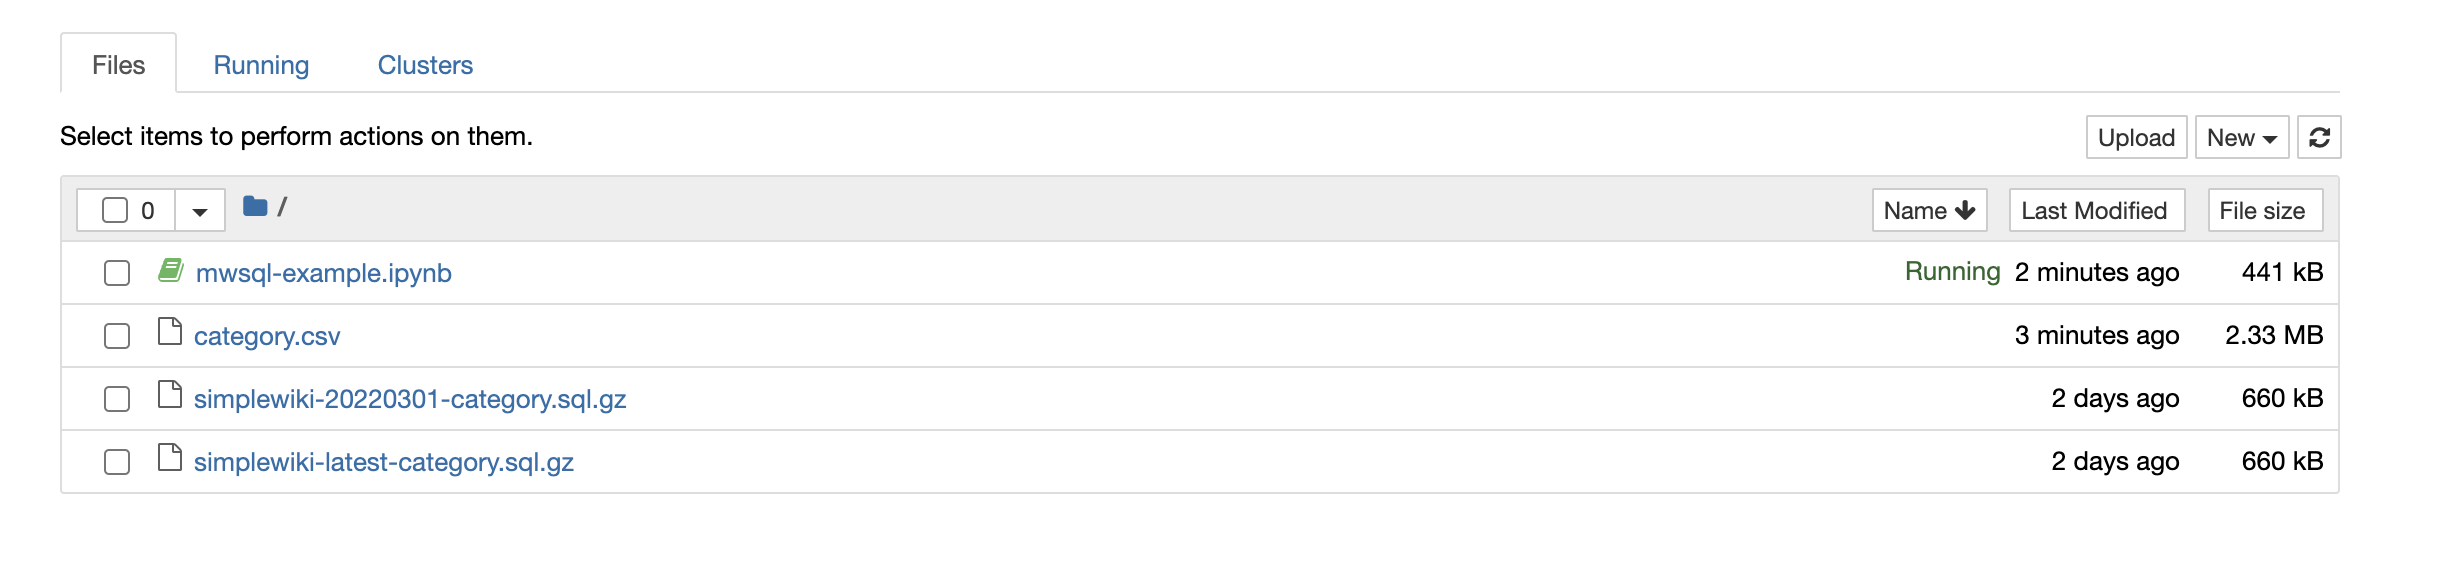

## Future of mwsql

As many of the dump files are huge (>10GB), having to download them before being able to process their contents can be time-consuming. This is less of a problem in a WMF-hosted environment, such as [PAWS](https://wikitech.wikimedia.org/wiki/PAWS), where the dumps are available through a public directory. Having the opportunity to inspect a file before committing to download all of it, as well as being able to process it as it is downloading (streaming), would be a huge performance improvement for users working in non-WMF environments.

## `mwsql` project info

The project [repository](https://github.com/mediawiki-utilities/python-mwsql) is hosted on GitHub. Anyone is welcome to submit a patch, file a bug report, request [new features](https://github.com/mediawiki-utilities/python-mwsql/issues), and help improve the existing documentation. Have you used `mwsql` to do something interesting with Wikimedia data? Leave a post on this [Talk page](https://wikitech.wikimedia.org/wiki/User_talk:Slavina_Stefanova), and together we can think of a way to showcase your work.

## Source code

The Jupyter notebook containing the [source code](https://github.com/blancadesal/wm-tutorials-and-blogposts/tree/main/mwsql-blogpost) for this blog post can be found on GitHub. Feel free to clone it, fork it, and adapt it to your needs.

## Further reading

This [tutorial](https://public.paws.wmcloud.org/User:Slst2020/mwsql-tutorial.ipynb) explains how you can use `mwsql` along with other tools from the mediawiki-utilities suite and Pandas to explore how mobile editing has evolved over time.